In [44]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from kmodes.kmodes import KModes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [63]:
df = pd.read_csv('https://raw.githubusercontent.com/binggas/public-dataset/main/bank%2Bmarketing/bank-additional/bank-additional-full-alt.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


- Same as before, we are going to identify a single customer using the combination of these columns:

  1. `age`
  2. `job`
  3. `marital`
  4. `education`
  5. `default`
  6. `housing`
  7. `loan`


- However, we are not going to comine the values into a single column.

- Instead, we are only going to get all the columns and get rid of the others. This way, we can use the columns as variables to be fed into the algorithm.


In [64]:
df = df[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']]
df.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


In [65]:
# lets shape the data
print('columns: ', df.shape[1])
print('rows: ', df.shape[0])

columns:  7
rows:  41188


- One customer may have multiple rows for different activity.

- We need to check how many duplicates are in the data.

In [66]:
# check duplicate
df.duplicated().sum()

28182

- Because our main goal is to segment each customer, unlike the campaign segmentation we did in the notebook before this, we want to get distinct customer by the combination of `age`, `job`, `marital`, `education`, `default`, `housing`, and `loan`.

In [67]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [68]:
# check null values in the data
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
housing      0
loan         0
dtype: int64

In [69]:
# check the type of the data
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
housing      object
loan         object
dtype: object

- To be able to do any calculatin with segmemtation algorithm, we need to make sure that the numerical columns are either type `int64` or `float` and that the categorical columns are type `category`.

- In this example, I will use categorical data for all columns to be able to use K-Mode method.

In [70]:
# List categorical columns
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# Loop each element within the list to be changed into the type `category`
for col in cat_cols:
    df[col] = df[col].astype('category')

# Check data types again
df.dtypes

age             int64
job          category
marital      category
education    category
default      category
housing      category
loan         category
dtype: object

In [71]:
# check unique data for every category type
for col in cat_cols:
    print(f'{col}:')
    print(df[col].unique())
    print('\n')

job:
['housemaid', 'services', 'admin.', 'blue-collar', 'technician', ..., 'unemployed', 'self-employed', 'unknown', 'entrepreneur', 'student']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'student', 'technician', 'unemployed', 'unknown']


marital:
['married', 'single', 'divorced', 'unknown']
Categories (4, object): ['divorced', 'married', 'single', 'unknown']


education:
['basic.4y', 'high.school', 'basic.6y', 'basic.9y', 'professional.course', 'unknown', 'university.degree', 'illiterate']
Categories (8, object): ['basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown']


default:
['no', 'unknown', 'yes']
Categories (3, object): ['no', 'unknown', 'yes']


housing:
['no', 'yes', 'unknown']
Categories (3, object): ['no', 'unknown', 'yes']


loan:
['no', 'yes', 'unknown']
Categories (3, object): ['no', 'unknown', 'yes']




- For the `age` column, we also want to convert it from `numerical` into `categorical`.

- We can achieve this by binning the values within the column. 

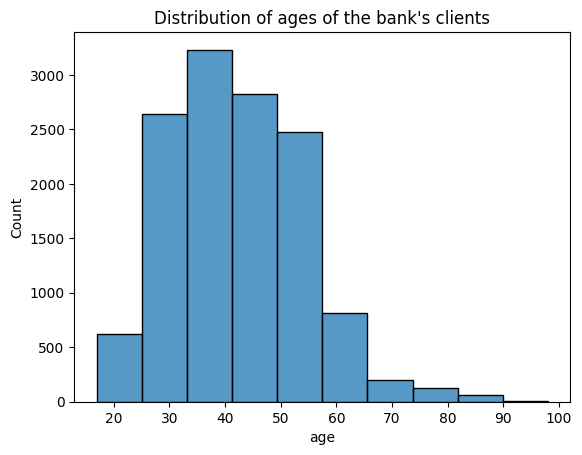

In [74]:
# Draw plot
sns.histplot(data=df,
            x='age',
            bins=10
            )

# Add title
plt.title("Distribution of ages of the bank's clients")

# Add label
plt.ylabel('Count')

# Show the plot
plt.show()

# Clustering using K-Modes

In [75]:
data_kmodes = df.copy()
data_kmodes.head()

,age,job,marital,education,default,housing,loan
0,56,housemaid,married,basic.4y,no,no,no
1,57,services,married,high.school,unknown,no,no
2,37,services,married,high.school,no,yes,no
3,40,admin.,married,basic.6y,no,no,no
4,56,services,married,high.school,no,no,yes


In [76]:
# Bin `age` column into 10 bins from 10 to 100, change type into category
data_kmodes['age_binned'] = pd.cut(data_kmodes['age'], bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]).astype('category')

# Drop `age` column
data_kmodes.drop('age', axis=1, inplace=True)

# Show first 5 rows
data_kmodes.head()

,job,marital,education,default,housing,loan,age_binned
0,housemaid,married,basic.4y,no,no,no,"(50, 60]"
1,services,married,high.school,unknown,no,no,"(50, 60]"
2,services,married,high.school,no,yes,no,"(30, 40]"
3,admin.,married,basic.6y,no,no,no,"(30, 40]"
4,services,married,high.school,no,no,yes,"(50, 60]"


## One-hot encoding

In [77]:
data_kmodes.head()

,job,marital,education,default,housing,loan,age_binned
0,housemaid,married,basic.4y,no,no,no,"(50, 60]"
1,services,married,high.school,unknown,no,no,"(50, 60]"
2,services,married,high.school,no,yes,no,"(30, 40]"
3,admin.,married,basic.6y,no,no,no,"(30, 40]"
4,services,married,high.school,no,no,yes,"(50, 60]"


In [78]:
print(data_kmodes.shape)

(13006, 7)


In [79]:
data_kmodes = pd.get_dummies(data_kmodes, drop_first=True)
data_kmodes.head()

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,loan_unknown,loan_yes,"age_binned_(20, 30]","age_binned_(30, 40]","age_binned_(40, 50]","age_binned_(50, 60]","age_binned_(60, 70]","age_binned_(70, 80]","age_binned_(80, 90]","age_binned_(90, 100]"
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,False


In [43]:
print(data_kmodes.shape)

(13006, 35)


## Feeding the Data into the Algorithm

In [80]:
# Running the K-Modes algorithm for different numbers of clusters:

n_clusters = list(range(2, 9))
costs = []

for n in n_clusters:
    kmodes = KModes(n_clusters=n, init='random', n_init=10, max_iter=500, random_state=42)
    kmodes.fit(data_kmodes)
    cost = kmodes.cost_
    costs.append(cost)

- Plot the simulation result of `cost` vs `number of cluster`.

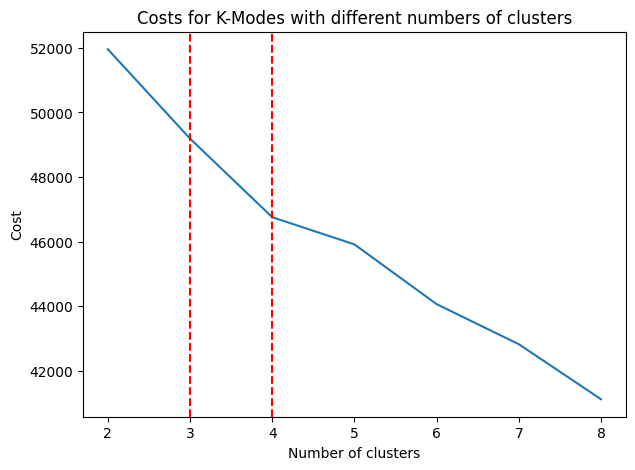

In [81]:
# Plotting the cost:

plt.figure(figsize=(7,5))
plt.plot(n_clusters, costs)
plt.axvline(3, linestyle='--', c='r')
plt.axvline(4, linestyle='--', c='r')
plt.xlabel('Number of clusters')
plt.ylabel('Cost')
plt.title('Costs for K-Modes with different numbers of clusters')
plt.show()

- We choose 4 clusters based on the elbow method.

## Label the Original Data

In [82]:
kmodes = KModes(n_clusters=4, init='random', n_init=10, max_iter=500, random_state=42)
df['cluster_k-modes'] = kmodes.fit_predict(data_kmodes)

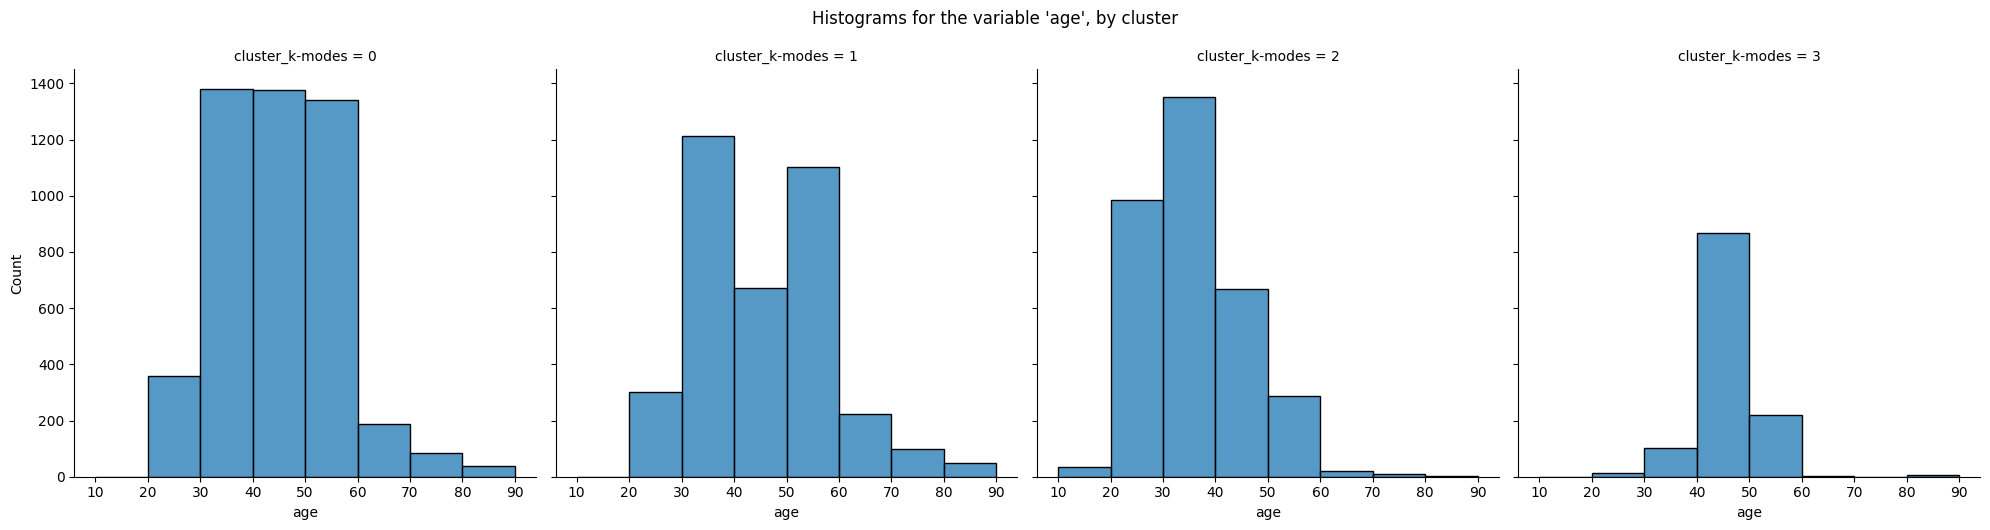

In [83]:
g = sns.displot(data=df,
                x='age',
                col='cluster_k-modes',
                bins=[10, 20, 30, 40, 50, 60, 70, 80, 90]
                )

g.fig.suptitle("Histograms for the variable 'age', by cluster", y=1.05)

plt.show()

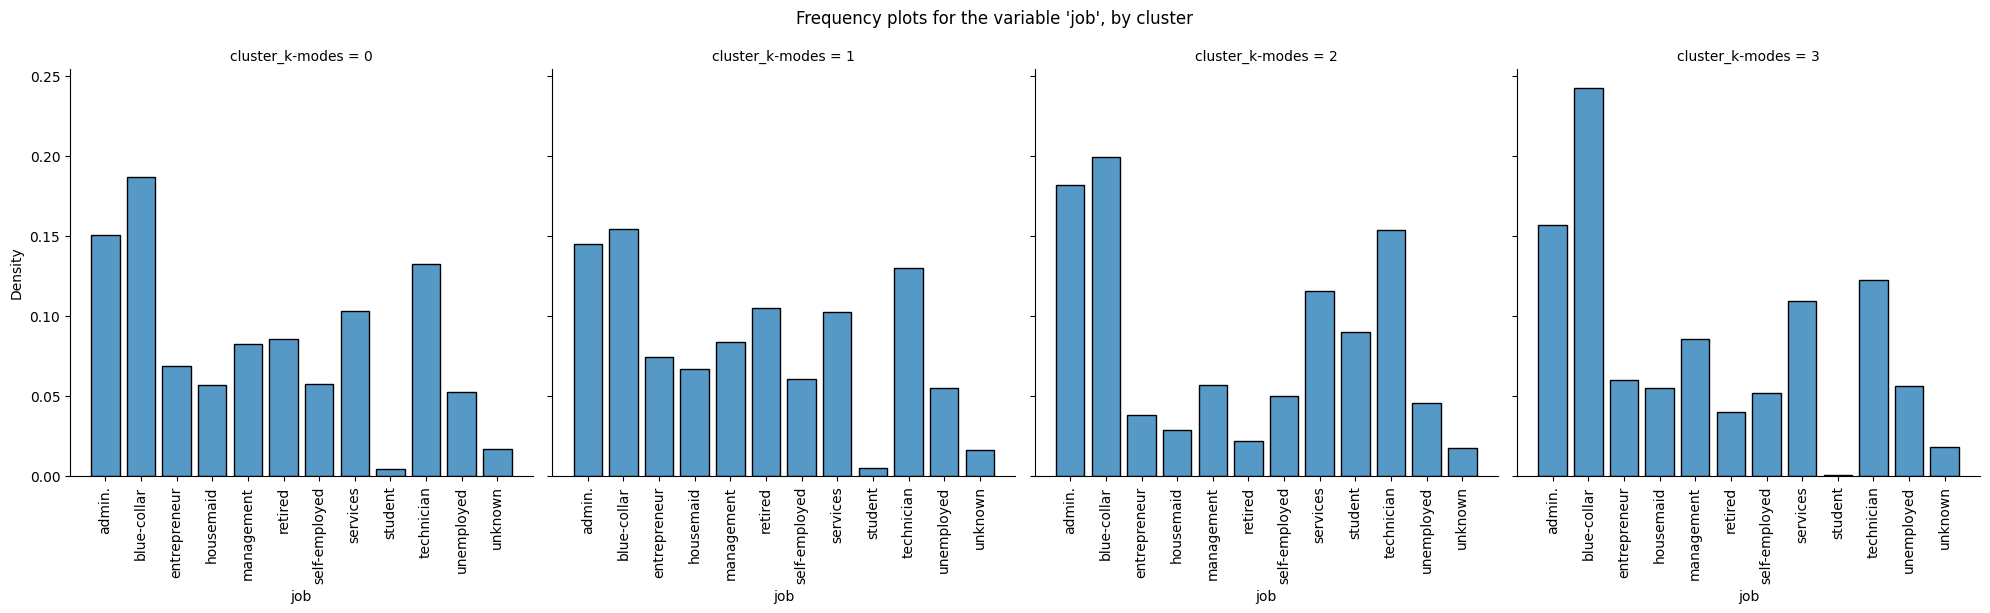

In [84]:
g = sns.displot(data=df,
                x='job',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'job', by cluster", y=1.05)

plt.show()

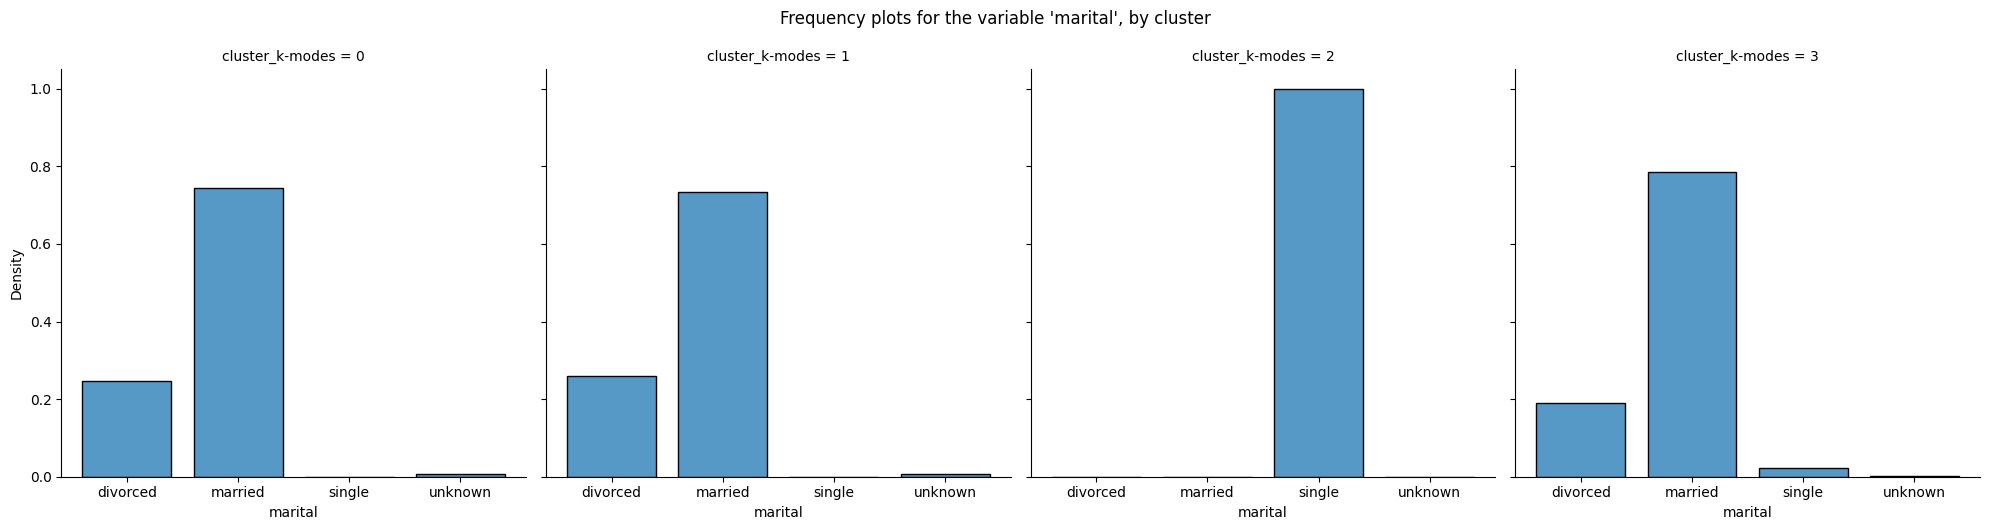

In [85]:
g = sns.displot(data=df,
                x='marital',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'marital', by cluster", y=1.05)

plt.show()

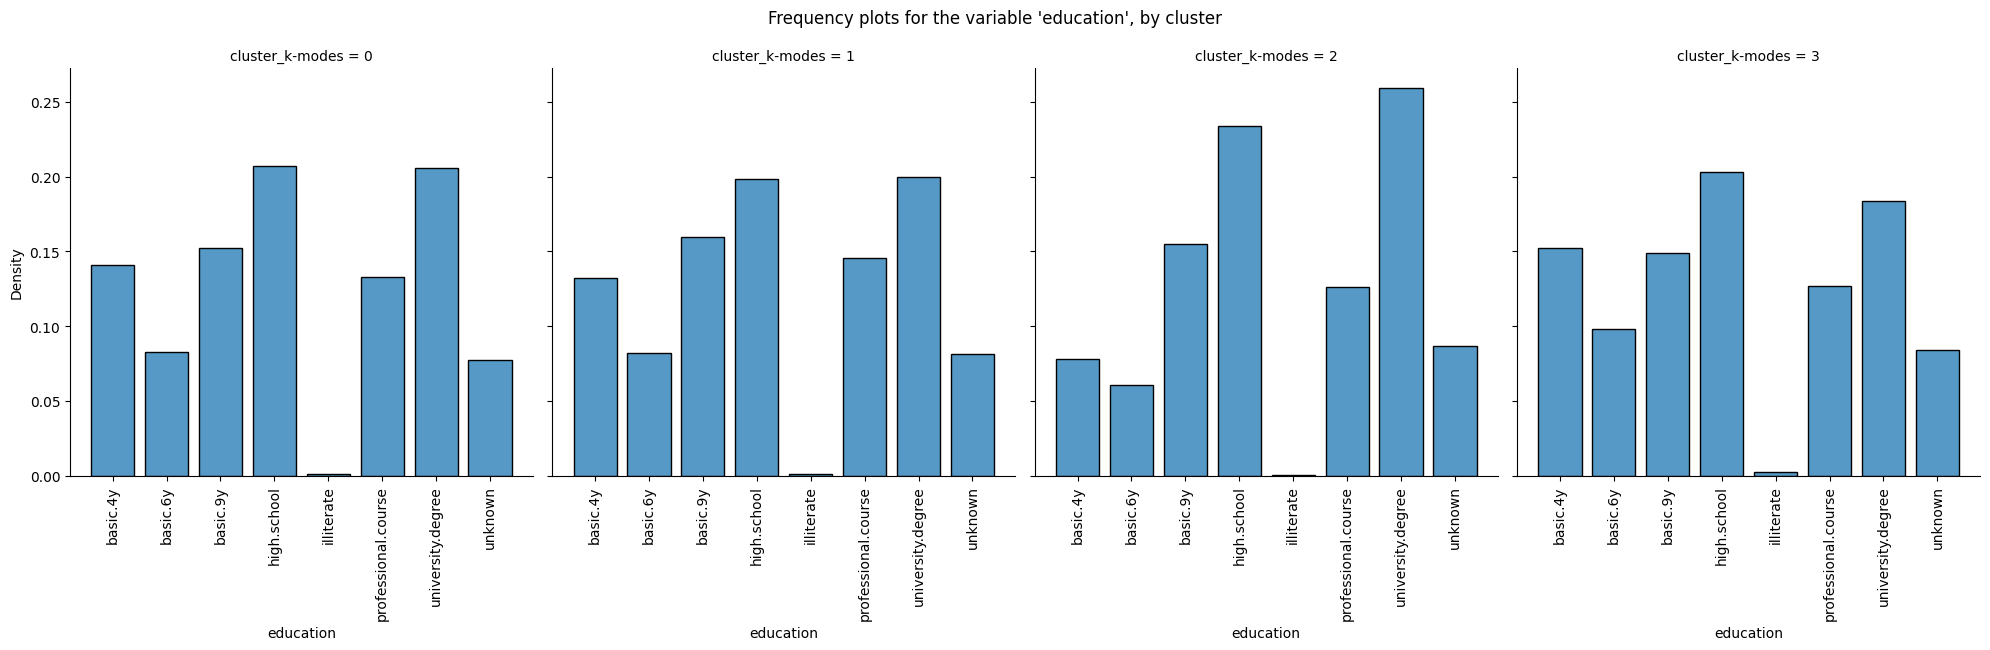

In [86]:
g = sns.displot(data=df,
                x='education',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.set_xticklabels(rotation=90)

g.fig.suptitle("Frequency plots for the variable 'education', by cluster", y=1.05)

plt.show()

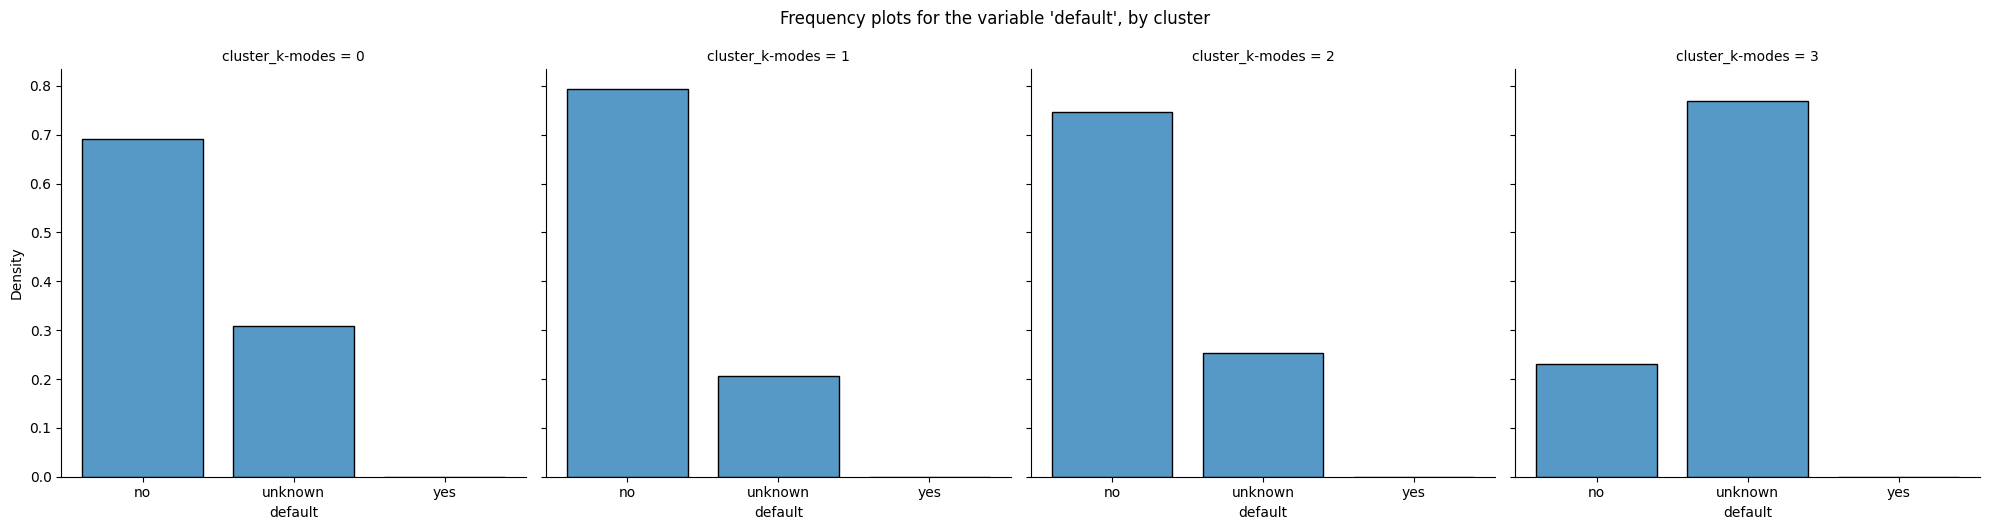

In [87]:
g = sns.displot(data=df,
                x='default',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'default', by cluster", y=1.05)

plt.show()

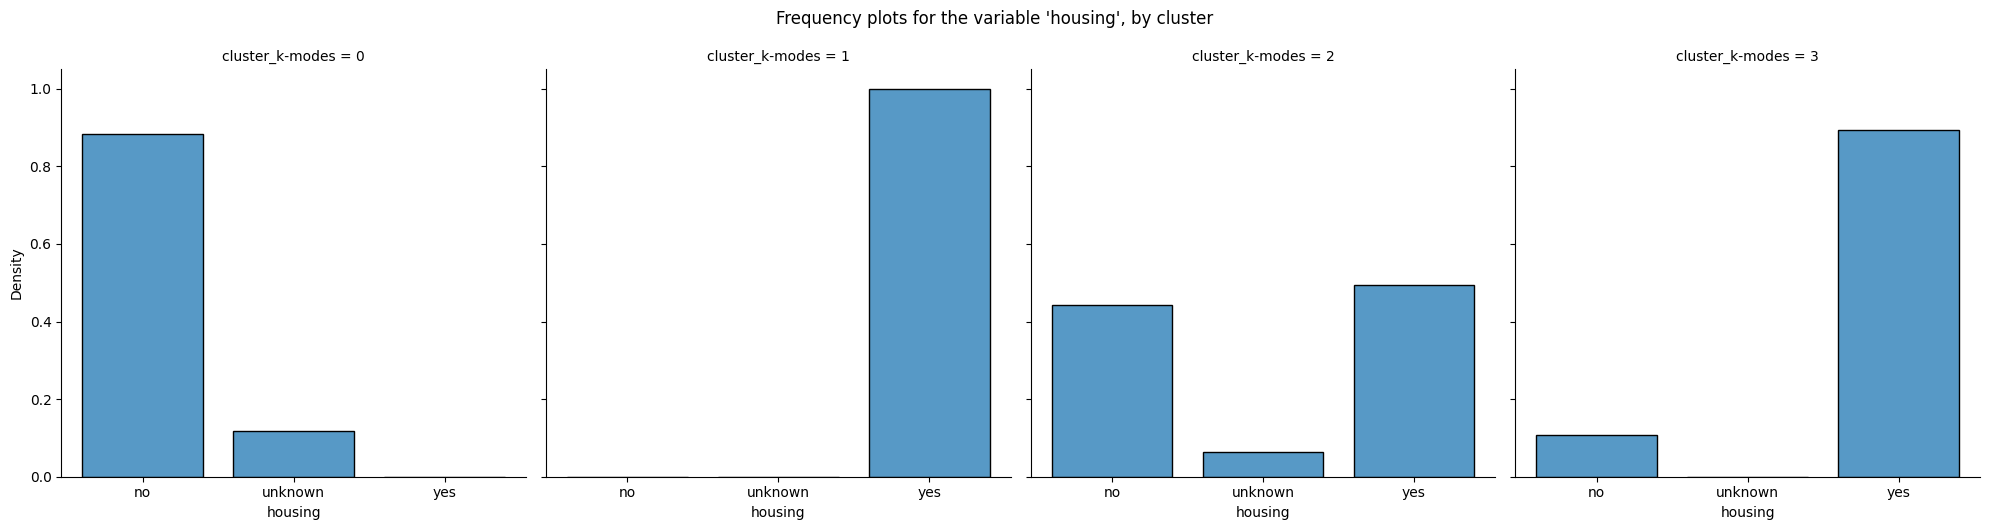

In [88]:
g = sns.displot(data=df,
                x='housing',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'housing', by cluster", y=1.05)

plt.show()

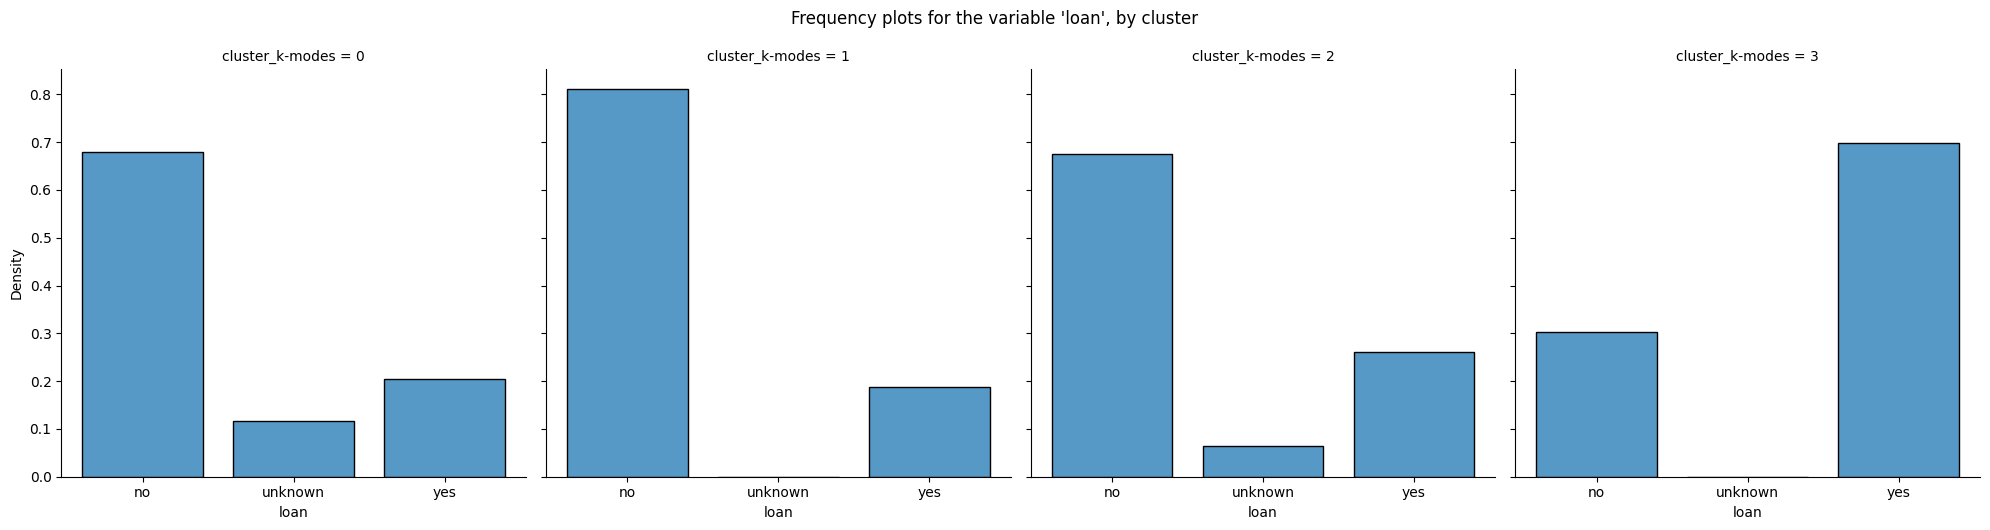

In [89]:
g = sns.displot(data=df,
                x='loan',
                col='cluster_k-modes',
                multiple="dodge",
                stat='density',
                shrink=0.8,
                common_norm=False)

g.fig.suptitle("Frequency plots for the variable 'loan', by cluster", y=1.05)

plt.show()

Based on the provided data and the clusters formed, we can glean several insights:

Cluster 1:

- Age: Predominantly individuals in the age range of 30-60.
- Job: Most common job categories are admin, blue-collar, and technician, suggesting a mix of white-collar and blue-collar workers.
- Marital Status: Primarily divorced and married individuals.
- Education: Mainly high-school and university-educated individuals.
- Default: These customers have a low rate of default, with no known defaults.
- Housing: Most of them do not have housing loans (no).
- Loan: A majority of these customers do not have personal loans.

Cluster 2:

- Age: Predominantly individuals in the age range of 30-60, similar to Cluster 1.
- Job: Similar to Cluster 1, with a concentration of admin, blue-collar, and technician roles.
- Marital Status: Mostly divorced and married.
- Education: Like Cluster 1, high-school and university education levels are common.
- Default: Similar to Cluster 1, most customers in this cluster have no known defaults.
- Housing: Unlike Cluster 1, many in this cluster have housing loans (yes).
- Loan: Similar to Cluster 1, a majority do not have personal loans.

Cluster 3:

- Age: Predominantly individuals in the age range of 20-40, suggesting a younger customer group.
- Job: This cluster includes individuals in services and student roles, indicating a different job profile compared to Clusters 1 and 2.
- Marital Status: Primarily single individuals, which is distinct from the other clusters.
- Education: Like the other clusters, high-school and university education levels are common.
- Default: This cluster has no known defaults.
- Housing: This cluster has a mix of customers, with some having housing loans (yes) and some not having them (no).
- Loan: Most customers in this cluster do not have personal loans.

Cluster 4:

- Age: Predominantly individuals in the age range of 40-50.
- Job: Similar to Clusters 1 and 2, with a concentration of admin, blue-collar, and technician roles.
- Marital Status: Mostly divorced and married.
- Education: Similar to the other clusters, high-school and university education levels are common.
- Default: This cluster includes customers with an unknown default status, indicating some uncertainty in this aspect.
- Housing: Most of the customers in this cluster have housing loans (yes).
- Loan: Many customers in this cluster have personal loans (yes).

In summary, the data and cluster analysis reveal the presence of distinct customer segments with variations in age, job profiles, marital status, housing and loan status, and default history. This information can be valuable for targeted marketing, product development, and risk assessment strategies, as it helps in understanding the diversity of customer groups within the dataset.